## Temporal_Classifier_V02
<br>

### Key Differences from "Devarshi_LightGBM_Classifier_Temporal_v01":
1. **Grouped** similar columns and summed their values.
2. **Removed** columns which did not seem impoortant.
3. **Updated** Accuracy, F1-score, Confusion Matrix, Cross Validation.
4. **Updated** Feature importance

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

---

## Train set:

In [2]:
df = pd.read_parquet("train_temporal_classification.parquet.gz", engine = "pyarrow") 

In [3]:
df.shape

(300960, 131)

In [4]:
train_start_date = '2017-01-01'
train_end_date = '2020-05-31'
df= df.loc[train_start_date:train_end_date]

In [5]:
df.shape

(246906, 131)

In [6]:
# combine high and vhigh to a single category, as we want to see how it will affect the accuracy of model
df['CAQI_level'] = df['CAQI_level'].replace({'vhigh':'high'})

In [7]:
df['CAQI_level'].value_counts()

low       108092
vlow      104899
medium     26066
high        7849
Name: CAQI_level, dtype: int64

In [8]:
# The ordered mapping of the labels to their categories 
mapping = {'vlow': 0, 'low': 1, 'medium': 2, 'high': 3}

df['CAQI_level'] = df['CAQI_level'].replace(mapping)

In [9]:
# encoding the other categorical columns:
cat_cols = ['powiat_voivod', 'voivodship', 'season', 'holiday_name']
for col in cat_cols:
    le = LabelEncoder()
    df['powiat_voivod_encoded'] = le.fit_transform(df['powiat_voivod'])
    df['voivodship_encoded'] = le.fit_transform(df['voivodship'])
    df['season_encoded'] = le.fit_transform(df['season'])
    df['holiday_name_encoded'] = le.fit_transform(df['holiday_name'])

In [10]:
# group similar cols together (and sum their values)
# https://github.com/OmdenaAI/warsaw-poland-chapter-air-pollution/blob/main/src/tasks/task-4-modeling/Joseph%20Antony_Modelling/1.%20BaseLine%20Model.ipynb
# https://github.com/OmdenaAI/warsaw-poland-chapter-air-pollution/blob/main/src/tasks/task-4-modeling/Vulcan_Catalin_modelling/LGBMClassifier.ipynb


df['emission of particules'] = df[[col for col in df.columns if col.startswith('emission of particulates ')]].sum(axis=1)
df = df.loc[:, ~df.columns.str.startswith('emission of particulates')]

df['emission of pollutant gasees'] = df[[col for col in df.columns if col.startswith('emission of pollutant gases ')]].sum(axis=1)
df = df.loc[:, ~df.columns.str.startswith('emission of pollutant gases ')]

df['total vehicles'] = df[[col for col in df.columns if col.startswith('total vehicles ')]].sum(axis=1)
df = df.loc[:, ~df.columns.str.startswith('total vehicles ')]

df['vehicles by type and fuel'] = df[[col for col in df.columns if col.startswith('vehicles by type and fuel ')]].sum(axis=1)
df = df.loc[:, ~df.columns.str.startswith('vehicles by type and fuel ')]

df['crop production'] = df[[col for col in df.columns if col.startswith('crop production ')]].sum(axis=1)
df = df.loc[:, ~df.columns.str.startswith('crop production ')]

df['air pollution reduction systems'] = df[[col for col in df.columns if col.startswith('air pollution reduction systems ')]].sum(axis=1)
df = df.loc[:, ~df.columns.str.startswith('air pollution reduction systems ')]

In [11]:
# drop cols

cols = [
        'production of electricity - water power plants and wind, biomass and wastes power plants, total',
        'production of electricity - water power plants',
        'production of electricity - thermal power plants, total',
        'production of electricity - thermal public power plants',
        'production of electricity - thermal autoproducing power plants',
        'production of electricity - from renewable energy sources',
        'production of electricity - share of renewable energy sources in total production of electricity',
        'production of electricity - relation of electricity production to electricity consumption',
        'forest fires - number of forest fires, total',
        'plants of significant nuisance - possessing systems to reduce the emission of gases',
        'plants of significant nuisance - possessing systems to reduce the emission of particulates',
        'season',
        'voivodship',
        'powiat_voivod',
        'holiday_name',
        'isUrban'
    ]
df.drop(columns=cols, inplace=True)
    

In [12]:
df.shape

(246906, 46)

In [13]:
# Remove any special characters from the column names
df.columns = [re.sub('[^0-9a-zA-Z]+', '_', col) for col in df.columns]

In [14]:
df.columns.tolist()

['cloud_cover',
 'wind_speed',
 'humidity',
 'precipitation',
 'snow_depth',
 'temperature',
 'animal_stock_total',
 'area_by_land_utilised_agricultural_area',
 'area_by_land_forests',
 'area_by_land_residential_areas',
 'area_by_land_industrial_lands',
 'area_by_land_recreational_and_rest_areas',
 'area_by_land_lands_under_waters',
 'area_by_land_wasteland',
 'area_by_land_other_area',
 'forest_area_forests_grand_total',
 'plants_of_significant_nuisance_total',
 'population_density_population_per_1_km2',
 'production_of_electricity_total',
 'share_of_green_areas_share_of_parks_lawns_and_green_areas_of_the_housing_estate_areas_in_the_total_area',
 'share_of_green_areas_share_of_green_areas_in_the_total_area',
 'share_of_urbanized_areas_total',
 'forest_fires_area_of_forest_fires_total',
 'CAQI_level',
 'day',
 'month',
 'year',
 'dayofweek',
 'CAQI_lag1',
 'is_school_holiday',
 'is_lockdown',
 'is_have_coalplant',
 'rolling7_CAQI',
 'rolling30_CAQI',
 'rolling90_CAQI',
 'is_weekend',
 

In [15]:
X_train = df.drop('CAQI_level', axis=1)
y_train = df['CAQI_level']

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 246906 entries, 2017-01-01 to 2020-05-31
Data columns (total 45 columns):
 #   Column                                                                                                   Non-Null Count   Dtype  
---  ------                                                                                                   --------------   -----  
 0   cloud_cover                                                                                              246906 non-null  float64
 1   wind_speed                                                                                               246906 non-null  float64
 2   humidity                                                                                                 246906 non-null  float64
 3   precipitation                                                                                            246906 non-null  float64
 4   snow_depth                                                

In [17]:
# initializing the LightGBM classifier
lgbm = LGBMClassifier()

# we fit the model on the training set
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [18]:
# Predict on the train set
y_pred = lgbm.predict(X_train)

# Accuracy score:
model_accuracy = accuracy_score(y_train, y_pred)
print("Model Accuracy:", model_accuracy)

Model Accuracy: 0.7725288166346707


In [19]:
from sklearn.metrics import f1_score

# y_test contains the true labels of the test set
# y_pred contains the predicted labels of the test set
f1 = f1_score(y_train, y_pred, average='micro')

print("Train F1 score:", f1)

Train F1 score: 0.7725288166346707


### Train F1 Score:

- Train set F1 Score is **0.7725**

---

## Test set:

In [20]:
test = pd.read_parquet("test_temporal_classification.parquet.gz", engine = "pyarrow") 
test.shape

(60390, 131)

In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60390 entries, 2021-03-02 to 2021-12-31
Columns: 131 entries, powiat_voivod to is_weekend
dtypes: float64(120), int32(1), int64(5), object(5)
memory usage: 60.6+ MB


In [22]:
test['CAQI_level'] = test['CAQI_level'].replace({'vhigh':'high'})
test['CAQI_level'].value_counts()

vlow      31913
low       24346
medium     3683
high        448
Name: CAQI_level, dtype: int64

In [23]:
# The ordered mapping of the labels to their categories 
mapping = {'vlow': 0, 'low': 1, 'medium': 2, 'high': 3}

test['CAQI_level'] = test['CAQI_level'].replace(mapping)

In [24]:
cat_cols = ['powiat_voivod', 'voivodship', 'season', 'holiday_name']
for col in cat_cols:
    le = LabelEncoder()
    test['powiat_voivod_encoded'] = le.fit_transform(test['powiat_voivod'])
    test['voivodship_encoded'] = le.fit_transform(test['voivodship'])
    test['season_encoded'] = le.fit_transform(test['season'])
    test['holiday_name_encoded'] = le.fit_transform(test['holiday_name'])

### Grouping similar columns together (and sum their values):

In [25]:
# https://github.com/OmdenaAI/warsaw-poland-chapter-air-pollution/blob/main/src/tasks/task-4-modeling/Joseph%20Antony_Modelling/1.%20BaseLine%20Model.ipynb
# https://github.com/OmdenaAI/warsaw-poland-chapter-air-pollution/blob/main/src/tasks/task-4-modeling/Vulcan_Catalin_modelling/LGBMClassifier.ipynb


test['emission of particules'] = test[[col for col in test.columns if col.startswith('emission of particulates ')]].sum(axis=1)
test = test.loc[:, ~test.columns.str.startswith('emission of particulates')]

test['emission of pollutant gasees'] = test[[col for col in test.columns if col.startswith('emission of pollutant gases ')]].sum(axis=1)
test = test.loc[:, ~test.columns.str.startswith('emission of pollutant gases ')]

test['total vehicles'] = test[[col for col in test.columns if col.startswith('total vehicles ')]].sum(axis=1)
test = test.loc[:, ~test.columns.str.startswith('total vehicles ')]

test['vehicles by type and fuel'] = test[[col for col in test.columns if col.startswith('vehicles by type and fuel ')]].sum(axis=1)
test = test.loc[:, ~test.columns.str.startswith('vehicles by type and fuel ')]

test['crop production'] = test[[col for col in test.columns if col.startswith('crop production ')]].sum(axis=1)
test = test.loc[:, ~test.columns.str.startswith('crop production ')]

test['air pollution reduction systems'] = test[[col for col in test.columns if col.startswith('air pollution reduction systems ')]].sum(axis=1)
test = test.loc[:, ~test.columns.str.startswith('air pollution reduction systems ')]

# drop cols

cols = [
        'production of electricity - water power plants and wind, biomass and wastes power plants, total',
        'production of electricity - water power plants',
        'production of electricity - thermal power plants, total',
        'production of electricity - thermal public power plants',
        'production of electricity - thermal autoproducing power plants',
        'production of electricity - from renewable energy sources',
        'production of electricity - share of renewable energy sources in total production of electricity',
        'production of electricity - relation of electricity production to electricity consumption',
        'forest fires - number of forest fires, total',
        'plants of significant nuisance - possessing systems to reduce the emission of gases',
        'plants of significant nuisance - possessing systems to reduce the emission of particulates',
        'season',
        'voivodship',
        'powiat_voivod',
        'holiday_name',
        'isUrban'
    ]
test.drop(columns=cols, inplace=True)

In [26]:
test.shape

(60390, 46)

In [27]:
# Remove any special characters from the column names
test.columns = [re.sub('[^0-9a-zA-Z]+', '_', col) for col in test.columns]

In [28]:
X_test = test.drop(['CAQI_level'], axis=1)
y_test = test['CAQI_level']

In [29]:
# initializing the LightGBM classifier
lgbm = LGBMClassifier()

# we fit the model on the training set
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [30]:
# Predict on the test set
y_pred = lgbm.predict(X_test)

# Accuracy score:
model_accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", model_accuracy)

Model Accuracy: 0.7528564331843021


- The overall accuracy of the model is 0.7528, indicating that **75.28%** of the predictions were correct.

---

### Model Evaluation:

In [31]:
# Evaluating the model performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82     31913
           1       0.70      0.72      0.71     24346
           2       0.55      0.36      0.43      3683
           3       0.40      0.23      0.29       448

    accuracy                           0.75     60390
   macro avg       0.61      0.53      0.56     60390
weighted avg       0.75      0.75      0.75     60390



Label encoding mapping: 'vlow': 0, 'low': 1, 'medium': 2, 'high': 3

In [32]:
from sklearn.metrics import f1_score

# y_test contains the true labels of the test set
# y_pred contains the predicted labels of the test set
f1 = f1_score(y_test, y_pred, average='micro')

print("Test F1 score:", f1)

Test F1 score: 0.7528564331843021


### F1 Scores: 

- The F1-score for class 0, the F1-score is 0.82, which is the weighted average of precision and recall. 
- Similarly, the F1-score for class 1 is 0.71, the F1-score for class 2 is 0.43, and the F1-score for class 3 is 0.29.
- View https://stephenallwright.com/good-f1-score/ to learn more about the F1 score and other classification measures.
<br> 

- Test set F1 Score is **0.7528**

--- 

## Confusion Matrix:

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

print(cm)

[[26574  5231   101     7]
 [ 6138 17478   700    30]
 [  102  2152  1310   119]
 [    3    74   268   103]]


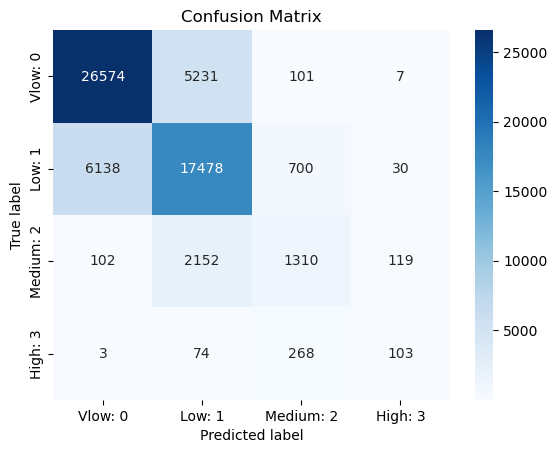

In [34]:
# Class labels
class_names = ['Vlow: 0', 'Low: 1', 'Medium: 2', 'High: 3']

# Heatmap plot of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Plot labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Based on the confusion matrix, we can see that:

- **26574** samples were correctly predicted as class 0 (true negatives).
- **17478** samples were correctly predicted as class 1 (true positives).
- **1310** samples were correctly predicted as class 2 (true positives).
- **103** samples were correctly predicted as class 3 (true positives).
<br>

- **5231** samples were incorrectly predicted as class 1, when the actual class was 0 (false positives).
- **2152** samples were incorrectly predicted as class 2, when the actual class was 0 (false positives).
- **3** samples were incorrectly predicted as class 3, when the actual class was 0 (false positives).
<br>

Overall, the confusion matrix provides a summary of the model's performance and helps to evaluate how well the model is able to correctly classify the samples.

---

## Feature Importance:

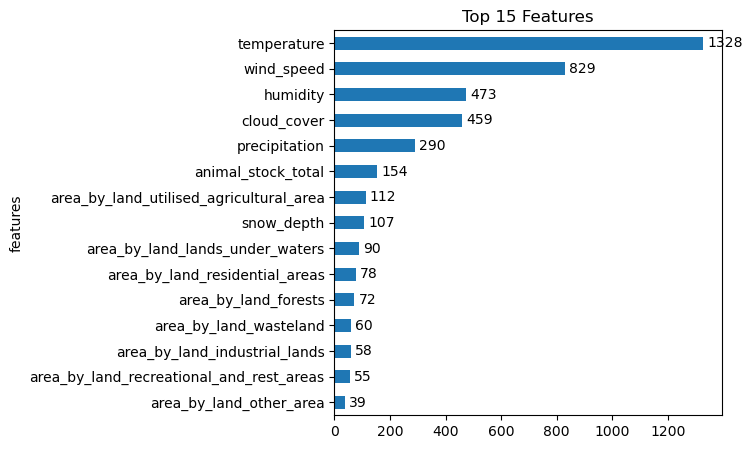

In [35]:
# get feature importances and corresponding feature names
importances = lgbm.feature_importances_
feature_names = X_train.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

#Creating a dataframe for feature importance
feat_imp_df = \
pd.DataFrame({
    'features': feature_names[:15],
    'importance': np.round(importances[:15], 4)
}).set_index('features').sort_values('importance')

ax = feat_imp_df.plot(kind='barh', figsize=(5, 5))
ax.set_title("Top 15 Features");
ax.bar_label(ax.containers[0], padding=3);
ax.legend().remove()
ax.figure.savefig('most_important_features.png', facecolor="white", bbox_inches='tight')

### Key observations:
- The main contributing features in our model are temperature, wind speed, humidity, and cloud cover.
- The most significant influences on 'CAQI level' appear to be temperature and wind speed.

---

## Cross validation:

In [36]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Lets create a TimeSeriesSplit object with the desired number of splits
tscv = TimeSeriesSplit(n_splits=5)

# The purpose of time series cross-validation is to simulate how the model will perform on new and unseen data, 
# so I will use the training set for defining X and y.
X = df.drop(['CAQI_level'], axis=1)
y = df['CAQI_level']

# create an empty list to store the accuracies for each split
accuracy_list = []

In [37]:
# loop over each split and fit the model
for train_index, test_index in tscv.split(X):
    # split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # fit the LightGBM classifier on the training data
    clf = LGBMClassifier()
    clf.fit(X_train, y_train)
    
    # prediction on the testing data and calculate accuracy
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)
    
# print the average accuracy across all splits
print('Average accuracy:', sum(accuracy_list)/len(accuracy_list))

Average accuracy: 0.7052076498748512


- Cross-validation using the TimeSeriesSplit method yields an average accuracy of **70.52%** across all splits.
- This means that the model has moderate predictive power.

--- 

### Plotting train and test targets to visually check:

In [38]:
X_train.index.year

Int64Index([2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
            ...
            2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019],
           dtype='int64', name='DATE', length=205755)

In [39]:
X_test.index.year

Int64Index([2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019,
            ...
            2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020],
           dtype='int64', name='DATE', length=41151)

In [40]:
y_train.index

DatetimeIndex(['2017-01-01', '2017-01-01', '2017-01-01', '2017-01-01',
               '2017-01-01', '2017-01-01', '2017-01-01', '2017-01-01',
               '2017-01-01', '2017-01-01',
               ...
               '2019-11-06', '2019-11-06', '2019-11-06', '2019-11-06',
               '2019-11-06', '2019-11-06', '2019-11-06', '2019-11-06',
               '2019-11-06', '2019-11-06'],
              dtype='datetime64[ns]', name='DATE', length=205755, freq=None)

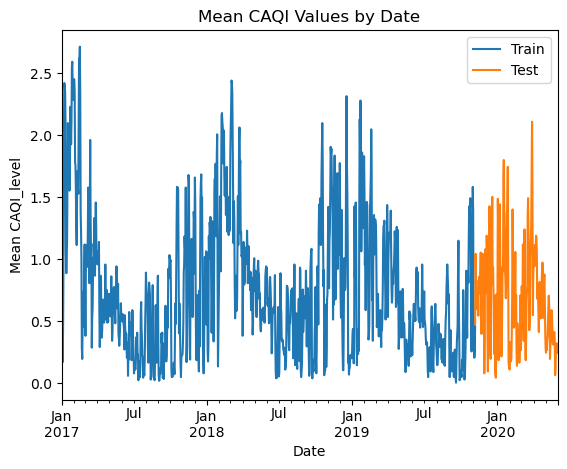

In [41]:
y_train.groupby('DATE').mean().plot()
y_test.groupby('DATE').mean().plot()

plt.legend(['Train', 'Test'])
plt.title('Mean CAQI Values by Date')
plt.xlabel('Date')
plt.ylabel('Mean CAQI_level')
plt.show()